In [1]:
import lightgbm
import pandas as pd
import shap
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv("data/census_income_test.csv", low_memory=False)
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16276,39,4,215419,9,13,0,10,1,4,0,0,0,36,39,0
16277,64,0,321403,11,9,6,0,2,2,1,0,0,40,39,0
16278,38,4,374983,9,13,2,10,0,4,1,0,0,50,39,0
16279,44,4,83891,9,13,0,1,3,1,1,5455,0,40,39,0


In [3]:
test_y = df["label"].to_list()
test_x = df.drop("label", axis=1).to_numpy()
assert len(test_x) == len(test_y)

In [4]:
bst = lightgbm.Booster(model_file="light_gbm.model")

In [5]:
# hack to avoid error
# KeyError: 'objective'
bst.params["objective"] = "binary"

In [6]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(test_x)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [7]:
# we just use shap_values[0] because shap_values[1] is the inverse
shap_values = shap_values[0]

In [8]:
# use absolute values
shap_values = np.absolute(shap_values)

In [9]:
shap_values = np.average(shap_values, axis=0)

In [10]:
feature_names = df.columns.to_list()
feature_names.remove("label")

In [11]:
list(zip(feature_names, shap_values))

[('age', 0.8540426962525411),
 ('workclass', 0.06133414082815983),
 ('fnlwgt', 0.09518607899168764),
 ('education', 0.02099251508270745),
 ('education-num', 0.4735359989492551),
 ('marital-status', 0.7459207692901046),
 ('occupation', 0.34376702267825976),
 ('relationship', 0.500575751192169),
 ('race', 0.04716332904268822),
 ('sex', 0.18283152978022532),
 ('capital-gain', 0.5885671056171572),
 ('capital-loss', 0.13999179674163642),
 ('hours-per-week', 0.34499393755261243),
 ('native-country', 0.030708127962071532)]

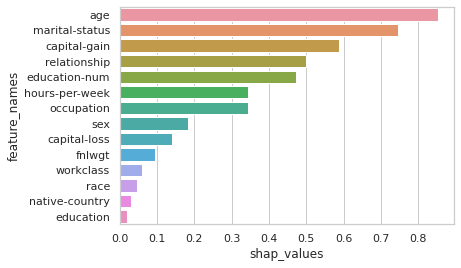

In [12]:
sns.set_theme(style="whitegrid")
shap_df = pd.DataFrame(data={"shap_values": shap_values.tolist(), "feature_names": feature_names})
shap_df.sort_values(by="shap_values", ascending=False, inplace=True)
ax = sns.barplot(x="shap_values", y="feature_names", data=shap_df)